In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tsfresh as tsf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [93]:
all_data = pd.read_csv("/Users/renzhiqiang/Workspace/data/iops-kpi/train.csv")
all_data["KPI ID"].unique()

array(['02e99bd4f6cfb33f', '9bd90500bfd11edb', 'da403e4e3f87c9e0',
       'a5bf5d65261d859a', '18fbb1d5a5dc099d', '09513ae3e75778a3',
       'c58bfcbacb2822d1', '1c35dbf57f55f5e4', '046ec29ddf80d62e',
       '07927a9a18fa19ae', '54e8a140f6237526', 'b3b2e6d1a791d63a',
       '8a20c229e9860d0c', '769894baefea4e9e', '76f4550c43334374',
       'e0770391decc44ce', '8c892e5525f3e491', '40e25005ff8992bd',
       'cff6d3c01e6a6bfa', '71595dd7171f4540', '7c189dd36f048a6c',
       'a40b1df87e3f1c87', '8bef9af9a922e0b3', 'affb01ca2b4f0b45',
       '9ee5879409dccef9', '88cf3a776ba00e7c'], dtype=object)

In [194]:
# df = pd.read_csv("../data/kpi.csv")
df=all_data[all_data["KPI ID"]=="40e25005ff8992bd"]
df['ts']=pd.to_datetime(df['timestamp'], unit='s')
df.index = df['ts']
df = df[['ts', 'value', 'label']]
df.head()

/var/folders/97/nf61081d1l7135m5v32qhhxc0000gn/T/ipykernel_97514/3545970459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ts']=pd.to_datetime(df['timestamp'], unit='s')


,ts,value,label
ts,,,
2017-06-01 03:36:00,2017-06-01 03:36:00,628.0,0
2017-06-01 03:37:00,2017-06-01 03:37:00,766.0,0
2017-06-01 03:38:00,2017-06-01 03:38:00,858.0,0
2017-06-01 03:39:00,2017-06-01 03:39:00,852.0,0
2017-06-01 03:40:00,2017-06-01 03:40:00,789.0,0


## 重采样&处理空值

In [195]:
resampled_df = df.resample('T').mean()
resampled_df['value'] = resampled_df['value'].fillna(method="ffill")
resampled_df['label'] = resampled_df['label'].fillna(0)

## 归一化

In [196]:
from sklearn.preprocessing import StandardScaler
X = resampled_df['value'].values.reshape(-1, 1)
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [197]:
resampled_df["scaled_value"]=scaled_X.ravel()

In [198]:
resampled_df.head()

,value,label,scaled_value
ts,,,
2017-06-01 03:36:00,628.0,0.0,-1.331226
2017-06-01 03:37:00,766.0,0.0,-1.076326
2017-06-01 03:38:00,858.0,0.0,-0.906393
2017-06-01 03:39:00,852.0,0.0,-0.917476
2017-06-01 03:40:00,789.0,0.0,-1.033843


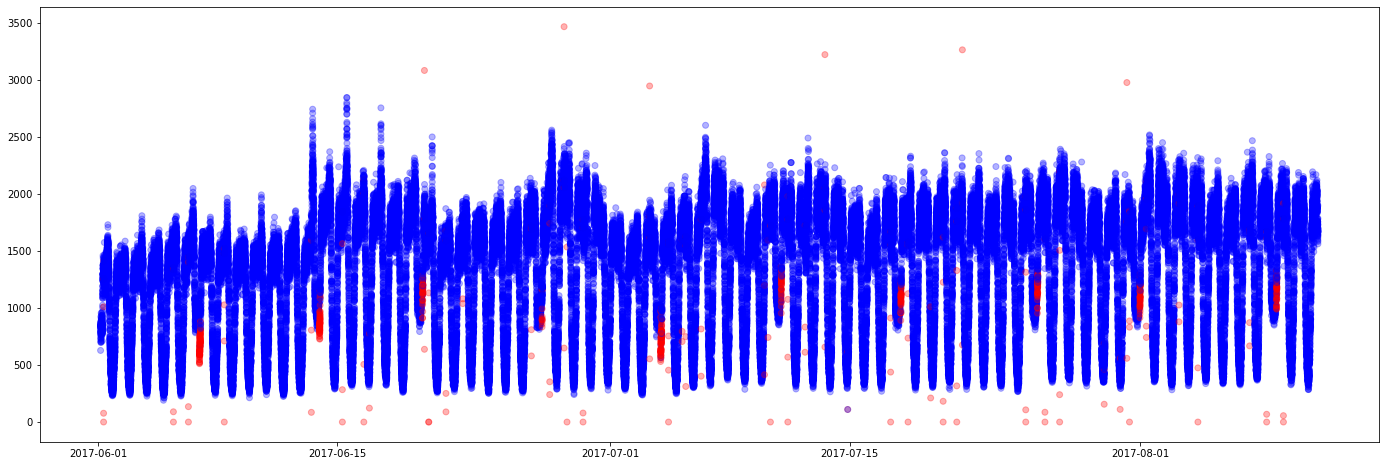

In [199]:
plt.rcParams['figure.figsize'] = (24,8)
resampled_df['date'] = resampled_df.index
plt.scatter(resampled_df.index, resampled_df['value'], c=['b' if l==0 else 'r' for l in resampled_df["label"]], alpha=0.3)
#resampled_df.plot(x="date", y="value", kind="scatter", c=['b' if l==0 else 'r' for l in df["label"]], alpha=0.3)
#df[df['label']==1].plot(x="ts", y="value", kind="scatter", c='r', alpha=0.6)
plt.show()

In [200]:
# %load '../learnware/feature/timeseries/feature_project.py'
import pandas as pd
import numpy as np
import tsfresh as tsf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing


def extracted_features(df, n=10):
    df = ts_time_feature_generate(df)
    df = ts_exponential_smoothing_feature_generate(df)
    df = ts_rolling_statistics_feature_generate(df, n)
    df = ts_lag_feature_generate(df, n)
    df = ts_linear_feature_generate(df, n)
    df = ts_seasonal_decompose(df)
    df = ts_fft_feature_generate(df, n)
    df = ts_wavelet_feature_generate(df, n)
    df = ts_wavelet_feature_generate(df, n)
    return df


def ts_time_feature_generate(data_df):
    # 时间特性，要看训练数据的时间区间这些值是否有价值
    data_df['quarter'] = data_df['ts'].dt.quarter
    data_df['month'] = data_df['ts'].dt.month
    data_df['day'] = data_df['ts'].dt.day
    data_df['dayofweek'] = data_df['ts'].dt.dayofweek
    data_df['weekofyear'] = data_df['ts'].dt.isocalendar().week
    data_df['hour'] = data_df['ts'].dt.hour

    # 这些特征一般跟业务属性强关系
    data_df['is_year_start'] = data_df['ts'].dt.is_year_start.astype(np.int)
    data_df['is_year_end'] = data_df['ts'].dt.is_year_end.astype(np.int)
    data_df['is_quarter_start'] = data_df['ts'].dt.is_quarter_start.astype(np.int)
    data_df['is_quarter_end'] = data_df['ts'].dt.is_quarter_end.astype(np.int)
    data_df['is_month_start'] = data_df['ts'].dt.is_month_start.astype(np.int)
    data_df['is_month_end'] = data_df['ts'].dt.is_month_end.astype(np.int)
    data_df['is_weekend'] = data_df['dayofweek'].apply(lambda x: 1 if x == 0 or x == 6 else 0)

    # 是否时一天的高峰时段 8~18
    data_df['day_high'] = data_df['hour'].apply(lambda x: 1 if 8 < x < 18 else 0)
    # 是否是批跑时段
    data_df['day_night'] = data_df['hour'].apply(lambda x: 1 if 0 < x < 6 else 0)

    return data_df


def ts_rolling_statistics_feature_generate(data_df, n):
    data_df[f'rolling_{n}_avg'] = data_df["value"].rolling(n).mean()
    data_df[f'rolling_{n}_median'] = data_df["value"].rolling(n).median()
    data_df[f'rolling_{n}_max'] = data_df["value"].rolling(n).max()
    data_df[f'rolling_{n}_min'] = data_df["value"].rolling(n).min()
    data_df[f'rolling_{n}_std'] = data_df["value"].rolling(n).std()
    data_df[f'rolling_{n}_var'] = data_df["value"].rolling(n).var()

    def mad(x):
        return np.fabs(x - x.mean()).mean()

    data_df[f'rolling_{n}_mad'] = data_df["value"].rolling(n).apply(mad, raw=True)
    data_df[f'rolling_{n}_skew'] = data_df["value"].rolling(n).skew()
    data_df[f'rolling_{n}_kurt'] = data_df["value"].rolling(n).kurt()
    data_df[f'rolling_{n}_corr'] = data_df["value"].rolling(n).corr()
    data_df[f'rolling_{n}_cov'] = data_df["value"].rolling(n).cov()
    data_df[f'rolling_{n}_q1'] = data_df["value"].rolling(n).quantile(0.25)
    data_df[f'rolling_{n}_q3'] = data_df["value"].rolling(n).quantile(0.75)
    data_df[f'rolling_{n}_ewma'] = data_df["value"].ewm(span=n).mean()

    return data_df


def ts_lag_feature_generate(data_df, *lags):
    data_df[f'diff_1'] = data_df["value"] - data_df["value"].shift(1)
    data_df[f'diff_1'] = data_df[f'diff_1'].fillna(value=0.0)
    data_df[f'diff_2'] = data_df["diff_1"] - data_df["diff_1"].shift(1)
    data_df[f'diff_2'] = data_df[f'diff_2'].fillna(value=0.0)
    for n in lags:
        data_df[f'ago_{n}_diff_1'] = (data_df["value"] - data_df["value"].shift(n)).fillna(value=0)
    return data_df


def ts_linear_feature_generate(data_df, n):
    data_df[f'rolling_{n}_linear_trend_slope'] = data_df["value"].rolling(n) \
        .apply(
        lambda data: list(tsf.feature_extraction.feature_calculators.linear_trend(data, [{'attr': 'slope'}]))[0][1])
    data_df[f'rolling_{n}_linear_trend_intercept'] = data_df["value"].rolling(n) \
        .apply(
        lambda data: list(tsf.feature_extraction.feature_calculators.linear_trend(data, [{'attr': 'intercept'}]))[0][1])

    return data_df


def ts_exponential_smoothing_feature_generate(data_df, seasonal=1440):
    data_df['smoothing_1exp'] = SimpleExpSmoothing(data_df["value"]).fit(smoothing_level=0.5).fittedvalues
    data_df['smoothing_2exp'] = ExponentialSmoothing(data_df["value"], trend="add", seasonal=None).fit().fittedvalues
    data_df['smoothing_3exp'] = ExponentialSmoothing(data_df["value"], trend="add", seasonal="add",
                                                     seasonal_periods=seasonal).fit().fittedvalues
    return data_df


def ts_seasonal_decompose(data_df, seasonal=1440):
    result_mul = seasonal_decompose(data_df['value'], model='additive', extrapolate_trend='freq', period=seasonal)
    data_df['seasonal_decompose_trend'] = result_mul.trend
    data_df['seasonal_decompose_seasonal'] = result_mul.seasonal
    data_df['seasonal_decompose_resid'] = result_mul.resid
    return data_df


def ts_fft_feature_generate(data_df, n):
    data_df[f'rolling_{n}_fft_agg_centroid'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'centroid'}]))[0][1])
    data_df[f'rolling_{n}_fft_agg_variance'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'variance'}]))[0][1])
    # 一般生成的是空值，暂时删除
    # data_df[f'rolling_{n}_fft_agg_skew']=data_df["value"].rolling(n)\
    #    .apply(lambda data:list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'skew'}]))[0][1])
    # data_df[f'rolling_{n}_fft_agg_kurtosis']=data_df["value"].rolling(n)\
    #    .apply(lambda data:list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'kurtosis'}]))[0][1])
    data_df[f'rolling_{n}_fft_coeff_angle'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'angle'}]))[
                   0][1])
    data_df[f'rolling_{n}_fft_coeff_real'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'real'}]))[
                   0][1])
    data_df[f'rolling_{n}_fft_coeff_abs'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'abs'}]))[0][
                   1])
    data_df[f'rolling_{n}_fft_coeff_imag'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'imag'}]))[
                   0][1])

    return data_df


def ts_wavelet_feature_generate(data_df, n):
    data_df[f'rolling_{n}_wavelet_cwt_coeff'] = data_df["value"].rolling(n) \
        .apply(lambda data: list(tsf.feature_extraction.feature_calculators.cwt_coefficients(data, [
        {'widths': tuple([2, 2, 2]), 'coeff': 2, 'w': 2}]))[0][1])
    return data_df


In [201]:
resampled_df['ts'] = resampled_df['date']

In [202]:
feature_df = extracted_features(resampled_df)

/Users/renzhiqiang/miniforge3/envs/aiops/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [203]:
f_df = feature_df[10:]

In [204]:
f_df = f_df.fillna(method='ffill')
f_df_adnormal = f_df[f_df["label"]==1]
adnormal_num = len(f_df_adnormal)
f_df_normal = f_df[f_df["label"]==0].sample(n=adnormal_num, random_state=42)

train_df = pd.concat([f_df_adnormal, f_df_normal])
train_df.head()

,value,label,scaled_value,date,ts,quarter,month,day,dayofweek,weekofyear,...,seasonal_decompose_trend,seasonal_decompose_seasonal,seasonal_decompose_resid,rolling_10_fft_agg_centroid,rolling_10_fft_agg_variance,rolling_10_fft_coeff_angle,rolling_10_fft_coeff_real,rolling_10_fft_coeff_abs,rolling_10_fft_coeff_imag,rolling_10_wavelet_cwt_coeff
ts,,,,,,,,,,,,,,,,,,,,,
2017-06-01 07:49:00,1415.0,1.0,0.122440,2017-06-01 07:49:00,2017-06-01 07:49:00,2,6,1,3,22,...,1004.231390,420.849862,-10.081252,0.143503,0.425393,74.381905,79.636215,295.799101,284.877485,1153.439900
2017-06-01 07:50:00,77.0,1.0,-2.348976,2017-06-01 07:50:00,2017-06-01 07:50:00,2,6,1,3,22,...,1004.240834,440.820988,-1368.061823,1.069980,2.848295,-121.680292,-632.596888,1204.535832,-1025.050120,1174.335450
2017-06-01 07:51:00,0.0,1.0,-2.491202,2017-06-01 07:51:00,2017-06-01 07:51:00,2,6,1,3,22,...,1004.250279,397.361260,-1401.611538,0.841281,1.508426,-80.374265,369.640873,2210.617452,-2179.494240,1189.437702
2017-06-01 07:52:00,1011.0,1.0,-0.623787,2017-06-01 07:52:00,2017-06-01 07:52:00,2,6,1,3,22,...,1004.259723,453.332227,-446.591949,0.833994,1.526283,-13.915358,2120.917874,2185.044444,-525.477493,1130.849092
2017-06-01 07:53:00,1256.0,1.0,-0.171249,2017-06-01 07:53:00,2017-06-01 07:53:00,2,6,1,3,22,...,1004.269167,396.331150,-144.600316,0.827688,1.498915,57.682601,1135.999407,2124.916330,1795.765785,1309.036014


In [205]:
columns = ['value', 'quarter', 'month', 'day', 'dayofweek',
       'weekofyear', 'hour', 'is_year_start', 'is_year_end',
       'is_quarter_start', 'is_quarter_end', 'is_month_start', 'is_month_end',
       'is_weekend', 'day_high', 'day_night', 'smoothing_1exp',
       'smoothing_2exp', 'smoothing_3exp', 'rolling_10_avg',
       'rolling_10_median', 'rolling_10_max', 'rolling_10_min',
       'rolling_10_std', 'rolling_10_var', 'rolling_10_mad', 'rolling_10_skew',
       'rolling_10_kurt', 'rolling_10_corr', 'rolling_10_cov', 'rolling_10_q1',
       'rolling_10_q3', 'rolling_10_ewma', 'diff_1', 'diff_2', 'ago_10_diff_1',
       'rolling_10_linear_trend_slope', 'rolling_10_linear_trend_intercept',
       'seasonal_decompose_trend', 'seasonal_decompose_seasonal',
       'seasonal_decompose_resid', 'rolling_10_fft_agg_centroid',
       'rolling_10_fft_agg_variance', 'rolling_10_fft_coeff_angle',
       'rolling_10_fft_coeff_real', 'rolling_10_fft_coeff_abs',
       'rolling_10_fft_coeff_imag', 'rolling_10_wavelet_cwt_coeff']
X = train_df[columns].values
y = train_df['label'].values

In [206]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=42), n_features_to_select=5, step=1)
fit = rfe.fit(X, y)

In [207]:
train_df[train_df.isnull().T.any()].head()

,value,label,scaled_value,date,ts,quarter,month,day,dayofweek,weekofyear,...,seasonal_decompose_trend,seasonal_decompose_seasonal,seasonal_decompose_resid,rolling_10_fft_agg_centroid,rolling_10_fft_agg_variance,rolling_10_fft_coeff_angle,rolling_10_fft_coeff_real,rolling_10_fft_coeff_abs,rolling_10_fft_coeff_imag,rolling_10_wavelet_cwt_coeff
ts,,,,,,,,,,,,,,,,,,,,,


In [211]:
selected_cols = [columns[i] for i, v in enumerate(fit.support_) if v]

print(selected_cols)

['dayofweek', 'rolling_10_min', 'rolling_10_linear_trend_slope', 'seasonal_decompose_seasonal', 'rolling_10_fft_agg_centroid']


In [219]:
train_df = resampled_df[10:]
all_X = train_df[selected_cols].values.reshape(-1, 1)
all_y = train_df["label"]

## 孤立森林异常检测

In [220]:
from sklearn.ensemble import IsolationForest
c = len(train_df[train_df['label']==1])/len(train_df)
iforest = IsolationForest(contamination=c)
iforest.fit(all_X)
pred = iforest.predict(all_X)
pred = np.where(pred==1, 0, 1)
train_df["iforest_pred"] = pred
print(c)

ValueError: Length of values (513175) does not match length of index (102635)

In [ ]:
plt.scatter(train_df.index, train_df['value'], c=['b' if l==0 else 'r' for l in train_df["iforest_pred"]], alpha=0.3)
plt.show()